# Analysis of housing prices in Portugal

In [376]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sb
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

#### Several datasets are being used to assess any relationship among housing and rental prices and other explanatory factors, such as construction costs, loan availability, inflation, and others deemed relevant.
#### Federal reserve was the main source of data for the present analysis

In [200]:
#import data from FRED
df_construction_cost = pd.read_csv('data/building_construction_cost_pt.csv')
df_cpi_pt = pd.read_csv('data/cpi_pt.csv')
df_credit_private_sector = pd.read_csv('data/credit_private_sector_pt.csv')
df_permits_issued = pd.read_csv('data/permits_issued_construction_pt.csv')
df_property_prices = pd.read_csv('data/property_prices_pt.csv')
df_rental_prices = pd.read_csv('data/rental_prices_pt.csv')
#import data from OECD
df_household_savings = pd.read_csv('data/household_savings_pt.csv')
df_disposable_income = pd.read_csv('data/disposable_income_pt.csv')

Check that all headers are correct

In [201]:
df_construction_cost.head()

,DATE,OPCNTB01PTM661N
0,2000-01-01,75.404007
1,2000-02-01,75.329053
2,2000-03-01,75.703824
3,2000-04-01,74.354647
4,2000-05-01,74.654464


In [202]:
df_cpi_pt.head()

,DATE,PRTCPIALLMINMEI
0,1960-01-01,1.104990
1,1960-02-01,1.111902
2,1960-03-01,1.122764
3,1960-04-01,1.100052
4,1960-05-01,1.089190


In [203]:
df_credit_private_sector.head()

,DATE,QPTPAMUSDA
0,1957-01-01,1.346
1,1957-04-01,1.398
2,1957-07-01,1.450
3,1957-10-01,1.502
4,1958-01-01,1.545


In [204]:
df_household_savings.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,PRT,HHSAV,TOT,PC_HHDI,A,2000,6.083532,NaN
1,PRT,HHSAV,TOT,PC_HHDI,A,2001,6.383318,NaN
2,PRT,HHSAV,TOT,PC_HHDI,A,2002,6.219463,NaN
3,PRT,HHSAV,TOT,PC_HHDI,A,2003,5.611222,NaN
4,PRT,HHSAV,TOT,PC_HHDI,A,2004,4.071028,NaN


In [205]:
df_permits_issued.head()

,DATE,PRTODCNPI03GPSAM
0,1994-02-01,-3.643652
1,1994-03-01,-1.122845
2,1994-04-01,2.660225
3,1994-05-01,0.582311
4,1994-06-01,2.041957


In [206]:
df_property_prices.head()

,DATE,QPTN628BIS
0,2008-01-01,101.7442
1,2008-04-01,102.0795
2,2008-07-01,99.2572
3,2008-10-01,97.5619
4,2009-01-01,98.4281


In [207]:
df_rental_prices.head()

,DATE,CP0410PTM086NEST
0,1996-01-01,62.94
1,1996-02-01,63.00
2,1996-03-01,63.06
3,1996-04-01,63.13
4,1996-05-01,63.19


In [208]:
df_construction_cost.head()

,DATE,OPCNTB01PTM661N
0,2000-01-01,75.404007
1,2000-02-01,75.329053
2,2000-03-01,75.703824
3,2000-04-01,74.354647
4,2000-05-01,74.654464


In [209]:
df_disposable_income.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,PRT,HHDI,GROSS,PC_CHGPPCAP,Q,2007-Q2,-2.25,NaN
1,PRT,HHDI,GROSS,PC_CHGPPCAP,Q,2007-Q3,1.25,NaN
2,PRT,HHDI,GROSS,PC_CHGPPCAP,Q,2007-Q4,-4.02,NaN
3,PRT,HHDI,GROSS,PC_CHGPPCAP,Q,2008-Q1,3.65,NaN
4,PRT,HHDI,GROSS,PC_CHGPPCAP,Q,2008-Q2,-1.39,NaN


Rename Column Headers

In [210]:
df_disposable_income = df_disposable_income.rename(columns={'TIME': 'date','Value': 'disposable_income_percent_change'})
df_household_savings = df_household_savings.rename(columns={'TIME': 'date', 'Value': 'household_savings_percent_of_income'})
df_construction_cost = df_construction_cost.rename(columns={'DATE': 'date', 'OPCNTB01PTM661N': 'construction_cost'})
df_cpi_pt = df_cpi_pt.rename(columns={'DATE': 'date', 'PRTCPIALLMINMEI': 'cpi'})
df_credit_private_sector =  df_credit_private_sector.rename(columns={'DATE': 'date', 'QPTPAMUSDA': 'credit_private_sector'})
df_permits_issued =  df_permits_issued.rename(columns={'DATE': 'date', 'PRTODCNPI03GPSAM': 'permits_issued'})
df_property_prices =  df_property_prices.rename(columns={'DATE': 'date', 'QPTN628BIS': 'property_prices'})
df_rental_prices =  df_rental_prices.rename(columns={'DATE': 'date', 'CP0410PTM086NEST': 'rental_prices'})

Check data types

In [211]:
print(df_disposable_income.dtypes)
print(df_household_savings.dtypes)
print(df_construction_cost.dtypes)
print(df_cpi_pt.dtypes)
print(df_credit_private_sector.dtypes)
print(df_permits_issued.dtypes)
print(df_property_prices.dtypes)
print(df_rental_prices.dtypes)

LOCATION                             object
INDICATOR                            object
SUBJECT                              object
MEASURE                              object
FREQUENCY                            object
date                                 object
disposable_income_percent_change    float64
Flag Codes                          float64
dtype: object
LOCATION                                object
INDICATOR                               object
SUBJECT                                 object
MEASURE                                 object
FREQUENCY                               object
date                                     int64
household_savings_percent_of_income    float64
Flag Codes                              object
dtype: object
date                  object
construction_cost    float64
dtype: object
date     object
cpi     float64
dtype: object
date                      object
credit_private_sector    float64
dtype: object
date               object
permits_issued    fl

Update date colums to datetime

In [212]:
# disposable income has dates by quarters
df_disposable_income['date'] = pd.to_datetime(df_disposable_income['date'])
df_household_savings['date'] = pd.to_datetime(df_household_savings['date'], format='%Y')
df_construction_cost['date'] = pd.to_datetime(df_construction_cost['date'])
df_cpi_pt['date'] = pd.to_datetime(df_cpi_pt['date'])
df_credit_private_sector['date'] = pd.to_datetime(df_credit_private_sector['date'])
df_permits_issued['date'] = pd.to_datetime(df_permits_issued['date'])
df_property_prices['date'] = pd.to_datetime(df_property_prices['date'])
df_rental_prices['date'] = pd.to_datetime(df_rental_prices['date'])

Change df_household_savings and df_disposable_income to match other dataframes structure

In [213]:
df_household_savings = df_household_savings.drop(columns=['LOCATION', 'INDICATOR', 'SUBJECT',
                                                          'MEASURE', 'FREQUENCY', 'Flag Codes'])

In [214]:
df_disposable_income = df_disposable_income.drop(columns=['LOCATION', 'INDICATOR', 'SUBJECT',
                                                          'MEASURE', 'FREQUENCY', 'Flag Codes'])

### Explanatory analysis

Merge all dataframes

In [216]:
df_merge_1 = pd.merge(df_disposable_income, df_household_savings, on='date', how='outer')
df_merge_2 = pd.merge(df_merge_1, df_construction_cost, on='date', how='outer')
df_merge_3 = pd.merge(df_merge_2, df_cpi_pt, on='date', how='outer')
df_merge_4 = pd.merge(df_merge_3, df_credit_private_sector, on='date', how='outer')
df_merge_5 = pd.merge(df_merge_4, df_permits_issued, on='date', how='outer')
df_merge_6 = pd.merge(df_merge_5, df_property_prices, on='date', how='outer')
df_combined = pd.merge(df_merge_6, df_rental_prices, on='date', how='outer')

In [217]:
df_combined.sort_values(by='date').head()

,date,disposable_income_percent_change,household_savings_percent_of_income,construction_cost,cpi,credit_private_sector,permits_issued,property_prices,rental_prices
760,1957-01-01,NaN,NaN,NaN,NaN,1.346,NaN,NaN,NaN
761,1957-04-01,NaN,NaN,NaN,NaN,1.398,NaN,NaN,NaN
762,1957-07-01,NaN,NaN,NaN,NaN,1.450,NaN,NaN,NaN
763,1957-10-01,NaN,NaN,NaN,NaN,1.502,NaN,NaN,NaN
764,1958-01-01,NaN,NaN,NaN,NaN,1.545,NaN,NaN,NaN


Let us just consider the values year >= 2000

In [218]:
df_combined = df_combined[df_combined['date']>='2000-01-01'].sort_values(by='date')

In [219]:
df_combined.sort_values(by='date').head()

,date,disposable_income_percent_change,household_savings_percent_of_income,construction_cost,cpi,credit_private_sector,permits_issued,property_prices,rental_prices
63,2000-01-01,NaN,6.083532,75.404007,72.002926,159.043,-5.821300,NaN,69.84
71,2000-02-01,NaN,NaN,75.329053,71.838720,NaN,22.705182,NaN,69.97
72,2000-03-01,NaN,NaN,75.703824,71.947195,NaN,-17.968314,NaN,70.03
73,2000-04-01,NaN,NaN,74.354647,72.786140,163.834,3.862632,NaN,70.09
74,2000-05-01,NaN,NaN,74.654464,73.196158,NaN,-11.641459,NaN,70.09


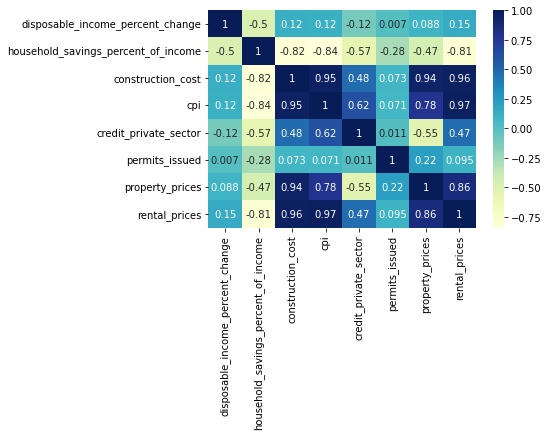

In [220]:
heatmap = sb.heatmap(df_combined.corr(), annot=True, cmap="YlGnBu")

We can see from the heatmap above that: 
- **consumer price index** and **construction costs**
- **property prices** and **construction costs**
- **construction costs** and **rental prices**
- **rental prices** and **property prices** <br> 
have a strong correlation.<br><br> On the opposite end, we see that:<br>
- **consumer prices index** and **household savings**
- **construction costs** and **household savings**
- **rental prices** and **household savings** <br>
have a strong negative correlation.

Let's build scatterplots and line graphs to visualy analyse these relationships

In [221]:
#CPI vs Constrution costs corr

#aggregate all graphs in one
fig_cpi_construction_costs = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {'rowspan':2}],
           [{}, None]],
    subplot_titles=("CPI","CPI vs Construction Costs","Construction costs"))


# line graph for CPI
fig_cpi_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['cpi']), row=1, col=1)


# line graph for construction Costs
fig_cpi_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['construction_cost']), 
                  row=2, col=1)


fig_cpi_construction_costs.add_trace(go.Scatter(
    x=df_combined['cpi'],
    y=df_combined['construction_cost'],
    mode='markers',
    name='Scatter'),
    row=1, col=2)


fig_cpi_construction_costs.show()

In [222]:
#Property Prices vs Constrution costs corr

#aggregate all graphs in one
fig_property_prices_construction_costs = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {'rowspan':2}],
           [{}, None]],
    subplot_titles=("Property Prices", "Property Prices vs Construction Costs","Construction costs"))


# line graph for property prices
fig_property_prices_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['property_prices'], mode='markers'), row=1, col=1)


# line graph for construction Costs
fig_property_prices_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['construction_cost']), 
                  row=2, col=1)


fig_property_prices_construction_costs.add_trace(go.Scatter(
    x=df_combined['property_prices'],
    y=df_combined['construction_cost'],
    mode='markers',
    name='Scatter'),
    row=1, col=2)


fig_property_prices_construction_costs.show()

In [223]:
#Rental prices vs Constrution costs corr

#aggregate all graphs in one
fig_rental_prices_construction_costs = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {'rowspan':2}],
           [{}, None]],
    subplot_titles=("Rental Prices","Rental Prices vs Construction Costs","Construction costs"))


# line graph for rental prices
fig_rental_prices_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['rental_prices']), row=1, col=1)


# line graph for construction Costs
fig_rental_prices_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['construction_cost']), 
                  row=2, col=1)


fig_rental_prices_construction_costs.add_trace(go.Scatter(
    x=df_combined['rental_prices'],
    y=df_combined['construction_cost'],
    mode='markers',
    name='Scatter'),
    row=1, col=2)

fig_rental_prices_construction_costs['layout']['xaxis2']['title']='rental prices'
fig_rental_prices_construction_costs['layout']['yaxis2']['title']='construction cost'
fig_rental_prices_construction_costs.show()

In [224]:
#Rental prices vs property prices corr

#aggregate all graphs in one
fig_rental_prices_property_prices = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {'rowspan':2}],
           [{}, None]],
    subplot_titles=("Rental Prices","Rental Prices vs Property Prices","Property Prices"))


# line graph for Rental Prices
fig_rental_prices_property_prices.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['rental_prices']), row=1, col=1)


# line graph for property prices Costs
fig_rental_prices_property_prices.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['property_prices'], mode='markers'), 
                  row=2, col=1)


fig_rental_prices_property_prices.add_trace(go.Scatter(
    x=df_combined['rental_prices'],
    y=df_combined['property_prices'],
    mode='markers',
    name='Scatter'),
    row=1, col=2)


fig_rental_prices_property_prices.show()

In [225]:
#CPIs vs Household Savings corr

#aggregate all graphs in one
fig_cpi_household_savings = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {'rowspan':2}],
           [{}, None]],
    subplot_titles=("CPI","CPI vs Household Savings","Household Savings"))


# line graph for CPI
fig_cpi_household_savings.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['cpi']), row=1, col=1)


# line graph for household savings
fig_cpi_household_savings.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['household_savings_percent_of_income'], mode='markers'), 
                  row=2, col=1)


fig_cpi_household_savings.add_trace(go.Scatter(
    x=df_combined['rental_prices'],
    y=df_combined['household_savings_percent_of_income'],
    mode='markers',
    name='Scatter'),
    row=1, col=2)


fig_cpi_household_savings.show()

In [226]:
#Household Savings vs Constrution costs corr

#aggregate all graphs in one
fig_household_savings_construction_costs = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {'rowspan':2}],
           [{}, None]],
    subplot_titles=("Household Savings","Household Savings vs Construction Costs","Construction costs"))


# line graph for household savings
fig_household_savings_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['household_savings_percent_of_income'], mode='markers'), row=1, col=1)


# line graph for construction Costs
fig_household_savings_construction_costs.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['construction_cost']), 
                  row=2, col=1)


fig_household_savings_construction_costs.add_trace(go.Scatter(
    x=df_combined['household_savings_percent_of_income'],
    y=df_combined['construction_cost'],
    mode='markers',
    name='Scatter'),
    row=1, col=2)


fig_household_savings_construction_costs.show()

In [227]:
#Household Savings vs Rental Prices corr

#aggregate all graphs in one
fig_household_savings_rental_prices = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {'rowspan':2}],
           [{}, None]],
    subplot_titles=("Household Savings","Household Savings vs Construction Costs","Construction costs"))


# line graph for household savings
fig_household_savings_rental_prices.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['household_savings_percent_of_income'], mode='markers'), row=1, col=1)


# line graph for rental prices
fig_household_savings_rental_prices.add_trace(go.Scatter(
                 x=df_combined['date'],
                 y=df_combined['rental_prices']), 
                  row=2, col=1)


fig_household_savings_rental_prices.add_trace(go.Scatter(
    x=df_combined['household_savings_percent_of_income'],
    y=df_combined['rental_prices'],
    mode='markers',
    name='Scatter'),
    row=1, col=2)


fig_household_savings_rental_prices.show()

# Data Engineering

Split data into train and test

Since household saving has too few observation in comparison, we will not include in the modelling

In [228]:
variables = ['disposable_income_percent_change', 'construction_cost',
            'cpi', 'credit_private_sector', 'permits_issued', 'property_prices', 'rental_prices']

In [322]:
# split data into training and test data
train, test = train_test_split(df_combined, test_size= 0.2, random_state= 3)

In [323]:
train = train.set_index('date').drop('household_savings_percent_of_income', axis=1)

Standardize data, as they have different scales

In [324]:
scaler = StandardScaler()
df_scaled = train.copy()
df_scaled[variables] = scaler.fit_transform(train[variables])


In [325]:
train = df_scaled.dropna().sort_values(by='date')

In [326]:
train

,disposable_income_percent_change,construction_cost,cpi,credit_private_sector,permits_issued,property_prices,rental_prices
date,,,,,,,
2008-01-01,1.681127,-0.372764,-0.332548,1.416786,1.464432,-0.407131,-0.571651
2008-04-01,-0.632287,-0.107941,-0.170098,1.570246,-0.218667,-0.394806,-0.491029
2008-07-01,2.553247,0.173010,-0.137452,1.138765,-1.118366,-0.498547,-0.450348
2008-10-01,-2.096531,-0.015422,-0.149181,1.059413,0.034187,-0.560863,-0.429638
2009-07-01,-1.247361,-0.217435,-0.279082,1.447477,0.046553,-0.493754,-0.286146
2009-10-01,1.401130,-0.191971,-0.282796,1.338288,-0.487980,-0.479033,-0.265436
2010-01-01,-1.311623,-0.231016,-0.298826,1.041561,-1.064749,-0.458147,-0.220317
2010-07-01,-0.627697,-0.099453,-0.108422,1.153832,-1.345026,-0.472527,-0.147831
2010-10-01,-0.274259,-0.077384,-0.070693,1.142497,0.050933,-0.510534,-0.150050


use Augmented Dickey-Fuller Test to check stationarity as it is an important assumption for further modelling, otherwise we may face spurious regression instead of actual causality

In [327]:
for variable in variables:
    result = adfuller(train[variable])
    print(f'{variable} Test Statistics: {result[0]}') 
    print(f'{variable} p-value: {result[1]}')
    print(f'{variable} critical_values: {result[4]}')
    if result[1] > 0.05:
        print(f"{variable} Series is not stationary\n\n")
    else:
        print(f"{variable} Series is stationary\n\n")

disposable_income_percent_change Test Statistics: -4.349868017191778
disposable_income_percent_change p-value: 0.00036371223348552673
disposable_income_percent_change critical_values: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}
disposable_income_percent_change Series is stationary


construction_cost Test Statistics: 1.1922822167722993
construction_cost p-value: 0.9959321244381886
construction_cost critical_values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
construction_cost Series is not stationary


cpi Test Statistics: 0.7933667546918778
cpi p-value: 0.9915283369989008
cpi critical_values: {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}
cpi Series is not stationary


credit_private_sector Test Statistics: -1.7307957761785846
credit_private_sector p-value: 0.41531946499189376
credit_private_sector critical_values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%':

#### Construction costs, cpi, credit to the private sector, property prices and rental prices are not stationary<br><br>Now we difference the series to make it stationary

In [328]:
# train['construction_cost_log'] = np.log(train['construction_cost'])
# train['cpi_log'] = np.log(train['cpi'])
# train['credit_private_sector_log'] = np.log(train['credit_private_sector'])
# train['property_prices_log'] = np.log(train['property_prices'])
# train['rental_prices_log'] = np.log(train['rental_prices'])

In [333]:
train['construction_cost_diff'] = train['construction_cost'] - train['construction_cost'].shift(1)
train['cpi_diff'] = train['cpi'] - train['cpi'].shift(1)
train['credit_private_sector_diff'] = train['credit_private_sector'] - train['credit_private_sector'].shift(1)
train['property_prices_diff'] = train['property_prices'] - train['property_prices'].shift(1)
train['rental_prices_diff'] = train['rental_prices'] - train['rental_prices'].shift(1)

In [335]:
train = train.dropna()

In [336]:
variables_diff = ['construction_cost_diff', 'cpi_diff', 'credit_private_sector_diff',
                  'property_prices_diff', 'rental_prices_diff']

In [337]:
for variable in variables_diff:
    result = adfuller(train[variable])
    print(f'{variable} Test Statistics: {result[0]}') 
    print(f'{variable} p-value: {result[1]}')
    print(f'{variable} critical_values: {result[4]}')
    if result[1] > 0.05:
        print(f"{variable} Series is not stationary\n\n")
    else:
        print(f"{variable} Series is stationary\n\n")

construction_cost_diff Test Statistics: 2.7828149368007242
construction_cost_diff p-value: 1.0
construction_cost_diff critical_values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
construction_cost_diff Series is not stationary


cpi_diff Test Statistics: -6.314957959039957
cpi_diff p-value: 3.167118646835104e-08
cpi_diff critical_values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}
cpi_diff Series is stationary


credit_private_sector_diff Test Statistics: -1.0619535042770953
credit_private_sector_diff p-value: 0.7300035789485239
credit_private_sector_diff critical_values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
credit_private_sector_diff Series is not stationary


property_prices_diff Test Statistics: 0.30909967578313424
property_prices_diff p-value: 0.9777581437247648
property_prices_diff critical_values: {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.

Analyse visualy the plots of the non stationary series

<AxesSubplot:xlabel='date'>

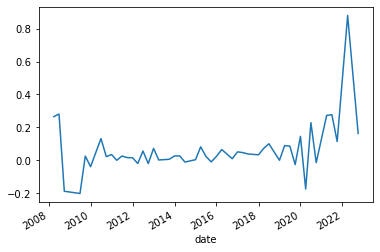

In [340]:
train['construction_cost_diff'].plot()

<AxesSubplot:xlabel='date'>

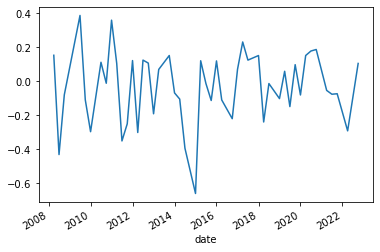

In [341]:
train['credit_private_sector_diff'].plot()

<AxesSubplot:xlabel='date'>

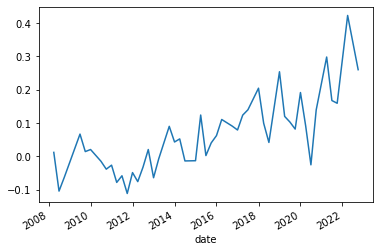

In [342]:
train['property_prices_diff'].plot()

Perform differencing once again

In [343]:
train['construction_cost_diff_2'] = train['construction_cost_diff'] - train['construction_cost_diff'].shift(1)
train['cpi_diff_2'] = train['cpi_diff'] - train['cpi_diff'].shift(1)
train['credit_private_sector_diff_2'] = train['credit_private_sector_diff'] - train['credit_private_sector_diff'].shift(1)
train['property_prices_diff_2'] = train['property_prices_diff'] - train['property_prices_diff'].shift(1)
train['rental_prices_diff_2'] = train['rental_prices_diff'] - train['rental_prices_diff'].shift(1)

C:\Users\UTILIZ~1\AppData\Local\Temp/ipykernel_20252/1420497338.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\UTILIZ~1\AppData\Local\Temp/ipykernel_20252/1420497338.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\UTILIZ~1\AppData\Local\Temp/ipykernel_20252/1420497338.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [344]:
train = train.dropna()

In [345]:
variables_diff_2 = ['construction_cost_diff_2', 'cpi_diff_2', 'credit_private_sector_diff_2',
                    'property_prices_diff_2', 'rental_prices_diff_2']

In [346]:
for variable in variables_diff_2:
    result = adfuller(train[variable])
    print(f'{variable} Test Statistics: {result[0]}') 
    print(f'{variable} p-value: {result[1]}')
    print(f'{variable} critical_values: {result[4]}')
    if result[1] > 0.05:
        print(f"{variable} Series is not stationary\n\n")
    else:
        print(f"{variable} Series is stationary\n\n")

construction_cost_diff_2 Test Statistics: -0.42901630098874266
construction_cost_diff_2 p-value: 0.9051402075278956
construction_cost_diff_2 critical_values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
construction_cost_diff_2 Series is not stationary


cpi_diff_2 Test Statistics: -8.548175273193717
cpi_diff_2 p-value: 9.378825099160473e-14
cpi_diff_2 critical_values: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
cpi_diff_2 Series is stationary


credit_private_sector_diff_2 Test Statistics: -4.906130827021083
credit_private_sector_diff_2 p-value: 3.3928638692700315e-05
credit_private_sector_diff_2 critical_values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
credit_private_sector_diff_2 Series is stationary


property_prices_diff_2 Test Statistics: -6.587441256427412
property_prices_diff_2 p-value: 7.254923611775905e-09
property_prices_diff_2 critical_values: {'1%': -3.588573

Visualise Construction Costs

<AxesSubplot:xlabel='date'>

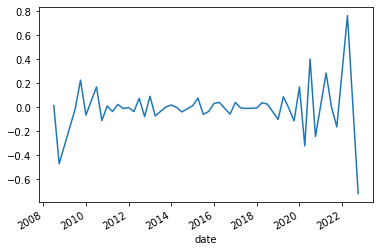

In [347]:
train['construction_cost_diff_2'].plot()

Do differencing once again

In [348]:
train['construction_cost_diff_3'] = train['construction_cost_diff_2'] - train['construction_cost_diff_2'].shift(1)

C:\Users\UTILIZ~1\AppData\Local\Temp/ipykernel_20252/3695367100.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [349]:
train= train.dropna()

In [350]:
variables_diff_3 = ['construction_cost_diff_3']

In [351]:
for variable in variables_diff_3:
    result = adfuller(train[variable])
    print(f'{variable} Test Statistics: {result[0]}') 
    print(f'{variable} p-value: {result[1]}')
    print(f'{variable} critical_values: {result[4]}')
    if result[1] > 0.05:
        print(f"{variable} Series is not stationary\n\n")
    else:
        print(f"{variable} Series is stationary\n\n")

construction_cost_diff_3 Test Statistics: -1.2325385716450692
construction_cost_diff_3 p-value: 0.6594442046800283
construction_cost_diff_3 critical_values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
construction_cost_diff_3 Series is not stationary




<AxesSubplot:xlabel='date'>

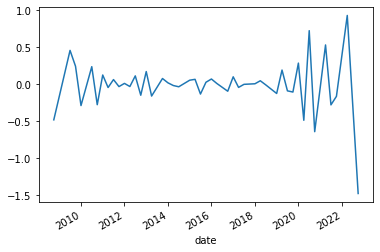

In [352]:
train['construction_cost_diff_3'].plot()

In [354]:
train['construction_cost_diff_4'] = train['construction_cost_diff_3'] - train['construction_cost_diff_3'].shift(1)

In [355]:
train= train.dropna()

In [356]:
variables_diff_4 = ['construction_cost_diff_4']

In [357]:
for variable in variables_diff_4:
    result = adfuller(train[variable])
    print(f'{variable} Test Statistics: {result[0]}') 
    print(f'{variable} p-value: {result[1]}')
    print(f'{variable} critical_values: {result[4]}')
    if result[1] > 0.05:
        print(f"{variable} Series is not stationary\n\n")
    else:
        print(f"{variable} Series is stationary\n\n")

construction_cost_diff_4 Test Statistics: -8.249895517426141
construction_cost_diff_4 p-value: 5.426521243297187e-13
construction_cost_diff_4 critical_values: {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}
construction_cost_diff_4 Series is stationary




<AxesSubplot:xlabel='date'>

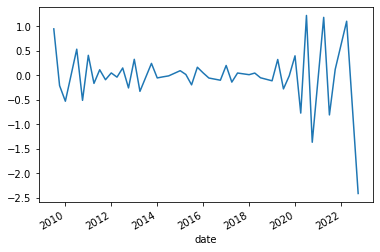

In [358]:
train['construction_cost_diff_4'].plot()

Aggregate all stationary series

In [360]:
train_stationary = train[['disposable_income_percent_change', 'permits_issued', 'cpi_diff',
                        'cpi_diff_2', 'credit_private_sector_diff_2',  'property_prices_diff_2',
                        'rental_prices_diff_2', 'construction_cost_diff_4']]

In [361]:
train_stationary

,disposable_income_percent_change,permits_issued,cpi_diff,rental_prices_diff,cpi_diff_2,credit_private_sector_diff_2,property_prices_diff_2,rental_prices_diff_2,construction_cost_diff_4
date,,,,,,,,,
2009-07-01,-1.247361,0.046553,-0.129901,0.143492,-0.118172,0.467416,0.129424,0.122782,0.941313
2009-10-01,1.401130,-0.487980,-0.003714,0.020710,0.126187,-0.497252,-0.052387,-0.122782,-0.214745
2010-01-01,-1.311623,-1.064749,-0.016030,0.045119,-0.012316,-0.187538,0.006164,0.024408,-0.533043
2010-07-01,-0.627697,-1.345026,0.190404,0.072486,0.206434,0.408997,-0.035265,0.027367,0.527101
2010-10-01,-0.274259,0.050933,0.037729,-0.002219,-0.152675,-0.123605,-0.023628,-0.074705,-0.515218
2011-01-01,-0.696549,0.047624,0.096864,0.006657,0.059135,0.371614,0.011987,0.008876,0.402328
2011-04-01,-0.219178,-0.072133,0.189818,0.045119,0.092954,-0.254897,-0.051700,0.038462,-0.169759
2011-07-01,-0.650648,-0.163670,-0.034112,0.006657,-0.223930,-0.456518,0.019857,-0.038462,0.107797
2011-10-01,-0.531305,-0.459598,0.135668,0.004438,0.169780,0.100759,-0.053067,-0.002219,-0.095065


Now that we have stationary data, let us move to feature selection

# Feature selection

Use the Granger Causality test to check if we shoud include the explanatory variables we have into a model

In [363]:
grangercausalitytests(train_stationary[['property_prices_diff_2', 'disposable_income_percent_change']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1843  , p=0.0105  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=7.7099  , p=0.0055  , df=1
likelihood ratio test: chi2=7.1042  , p=0.0077  , df=1
parameter F test:         F=7.1843  , p=0.0105  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1500  , p=0.0542  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=7.1289  , p=0.0283  , df=2
likelihood ratio test: chi2=6.5961  , p=0.0370  , df=2
parameter F test:         F=3.1500  , p=0.0542  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7808  , p=0.1688  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=6.4109  , p=0.0932  , df=3
likelihood ratio test: chi2=5.9664  , p=0.1133  , df=3
parameter F test:         F=1.7808  , p=0.1688  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1151  , p=0.3666  , df_d

{1: ({'ssr_ftest': (7.18425340008877, 0.010543254875761899, 41.0, 1),
   'ssr_chi2test': (7.709930478144046, 0.005491786669870359, 1),
   'lrtest': (7.104249153419659, 0.007690143132829337, 1),
   'params_ftest': (7.184253400088778, 0.01054325487576187, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.1499745877133183, 0.05422842666529781, 38.0, 2),
   'ssr_chi2test': (7.128889856403825, 0.02831269670282381, 2),
   'lrtest': (6.59608691182666, 0.03695540158595695, 2),
   'params_ftest': (3.149974587713339, 0.054228426665296876, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.7808178698080857, 0.168796044205663, 35.0, 3),
   'ssr_chi2test': (6.410944331309107, 0.0932415853645192, 3),
   'lrtest': (5.9663642818532026, 0.11325819263303687, 3),
   'params_ftest': (1.780817869808047, 0.16879604420567057, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 

In [365]:
grangercausalitytests(train_stationary[['property_prices_diff_2', 'permits_issued']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0656  , p=0.7992  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.0704  , p=0.7908  , df=1
likelihood ratio test: chi2=0.0703  , p=0.7909  , df=1
parameter F test:         F=0.0656  , p=0.7992  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9287  , p=0.0656  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=6.6280  , p=0.0364  , df=2
likelihood ratio test: chi2=6.1643  , p=0.0459  , df=2
parameter F test:         F=2.9287  , p=0.0656  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0468  , p=0.1252  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=7.3686  , p=0.0610  , df=3
likelihood ratio test: chi2=6.7891  , p=0.0789  , df=3
parameter F test:         F=2.0468  , p=0.1252  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8874  , p=0.1368  , df_d

{1: ({'ssr_ftest': (0.06557054931741864, 0.7991791922837777, 41.0, 1),
   'ssr_chi2test': (0.07036839438942488, 0.7908011518288036, 1),
   'lrtest': (0.07031218486898183, 0.7908827806789785, 1),
   'params_ftest': (0.0655705493174205, 0.7991791922837777, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.9286547720262326, 0.0656282162292969, 38.0, 2),
   'ssr_chi2test': (6.628008168269895, 0.03637025225767718, 2),
   'lrtest': (6.164275297510812, 0.0458611168328681, 2),
   'params_ftest': (2.9286547720262197, 0.06562821622929754, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.0468227398055867, 0.12516708737508186, 35.0, 3),
   'ssr_chi2test': (7.368561863300112, 0.061033598044092315, 3),
   'lrtest': (6.789056559349461, 0.07893398962317442, 3),
   'params_ftest': (2.0468227398055814, 0.12516708737508284, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

In [367]:
grangercausalitytests(train_stationary[['property_prices_diff_2', 'credit_private_sector_diff_2']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4522  , p=0.5051  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.4853  , p=0.4860  , df=1
likelihood ratio test: chi2=0.4826  , p=0.4872  , df=1
parameter F test:         F=0.4522  , p=0.5051  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1117  , p=0.8946  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=0.2528  , p=0.8812  , df=2
likelihood ratio test: chi2=0.2521  , p=0.8816  , df=2
parameter F test:         F=0.1117  , p=0.8946  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1119  , p=0.9526  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=0.4027  , p=0.9397  , df=3
likelihood ratio test: chi2=0.4008  , p=0.9401  , df=3
parameter F test:         F=0.1119  , p=0.9526  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2148  , p=0.9283  , df_d

{1: ({'ssr_ftest': (0.4521887311348108, 0.5050696982254286, 41.0, 1),
   'ssr_chi2test': (0.48527571146174814, 0.4860423043299241, 1),
   'lrtest': (0.48261917491092277, 0.48723832719499893, 1),
   'params_ftest': (0.4521887311348225, 0.5050696982254219, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.11171816556677171, 0.8945888950360559, 38.0, 2),
   'ssr_chi2test': (0.25283584838795703, 0.8812464755901532, 2),
   'lrtest': (0.25209542419668196, 0.8815727840926051, 2),
   'params_ftest': (0.11171816556677774, 0.8945888950360502, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.11186772670561886, 0.9525898901024439, 35.0, 3),
   'ssr_chi2test': (0.40272381614022784, 0.9396792451535294, 3),
   'lrtest': (0.40080527919118936, 0.9400760927978613, 3),
   'params_ftest': (0.11186772670561591, 0.9525898901024454, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

In [369]:
grangercausalitytests(train_stationary[['property_prices_diff_2', 'rental_prices_diff_2']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9108  , p=0.3455  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.9775  , p=0.3228  , df=1
likelihood ratio test: chi2=0.9668  , p=0.3255  , df=1
parameter F test:         F=0.9108  , p=0.3455  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2277  , p=0.3043  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=2.7785  , p=0.2493  , df=2
likelihood ratio test: chi2=2.6925  , p=0.2602  , df=2
parameter F test:         F=1.2277  , p=0.3043  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1764  , p=0.3327  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=4.2352  , p=0.2372  , df=3
likelihood ratio test: chi2=4.0350  , p=0.2577  , df=3
parameter F test:         F=1.1764  , p=0.3327  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1543  , p=0.3492  , df_d

{1: ({'ssr_ftest': (0.910826008362438, 0.34548865751354996, 41.0, 1),
   'ssr_chi2test': (0.9774718138523725, 0.32282377264914275, 1),
   'lrtest': (0.9667725820723092, 0.32548640868708284, 1),
   'params_ftest': (0.9108260083624454, 0.34548865751354607, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.2277241616424517, 0.30431614039447824, 38.0, 2),
   'ssr_chi2test': (2.778533628980285, 0.24925798999883586, 2),
   'lrtest': (2.6924522023327313, 0.2602204555780765, 2),
   'params_ftest': (1.2277241616424421, 0.3043161403944817, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.1764350770969652, 0.3326807293549961, 35.0, 3),
   'ssr_chi2test': (4.235166277549075, 0.23716457322269635, 3),
   'lrtest': (4.034984734048919, 0.25771110693851873, 3),
   'params_ftest': (1.1764350770969607, 0.33268072935499676, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

In [370]:
grangercausalitytests(train_stationary[['property_prices_diff_2', 'construction_cost_diff_4']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3998  , p=0.5307  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.4290  , p=0.5125  , df=1
likelihood ratio test: chi2=0.4270  , p=0.5135  , df=1
parameter F test:         F=0.3998  , p=0.5307  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0552  , p=0.9464  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=0.1249  , p=0.9394  , df=2
likelihood ratio test: chi2=0.1247  , p=0.9395  , df=2
parameter F test:         F=0.0552  , p=0.9464  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1086  , p=0.9545  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=0.3910  , p=0.9421  , df=3
likelihood ratio test: chi2=0.3892  , p=0.9425  , df=3
parameter F test:         F=0.1086  , p=0.9545  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2554  , p=0.9042  , df_d

{1: ({'ssr_ftest': (0.3997788094950307, 0.5307138912109857, 41.0, 1),
   'ssr_chi2test': (0.4290309175068622, 0.5124648457284353, 1),
   'lrtest': (0.4269527392621626, 0.513487993370015, 1),
   'params_ftest': (0.39977880949503264, 0.5307138912109857, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.05519856991188406, 0.9463729546953037, 38.0, 2),
   'ssr_chi2test': (0.12492307927426394, 0.9394491936755531, 2),
   'lrtest': (0.12474196745682775, 0.9395342702030138, 2),
   'params_ftest': (0.05519856991189083, 0.9463729546952977, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.10860623980930526, 0.954507213869316, 35.0, 3),
   'ssr_chi2test': (0.3909824633134989, 0.9420989426265218, 3),
   'lrtest': (0.3891738305021022, 0.9424697357999623, 3),
   'params_ftest': (0.10860623980930051, 0.9545072138693191, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

Now let's do the same but in reverse

In [371]:
grangercausalitytests(train_stationary[[ 'disposable_income_percent_change', 'property_prices_diff_2']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2875  , p=0.5947  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.3086  , p=0.5786  , df=1
likelihood ratio test: chi2=0.3075  , p=0.5792  , df=1
parameter F test:         F=0.2875  , p=0.5947  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0526  , p=0.9489  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=0.1190  , p=0.9423  , df=2
likelihood ratio test: chi2=0.1188  , p=0.9423  , df=2
parameter F test:         F=0.0526  , p=0.9489  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6555  , p=0.5849  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=2.3598  , p=0.5012  , df=3
likelihood ratio test: chi2=2.2959  , p=0.5133  , df=3
parameter F test:         F=0.6555  , p=0.5849  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8243  , p=0.0410  , df_d

{1: ({'ssr_ftest': (0.2875262151908317, 0.5947076828090652, 41.0, 1),
   'ssr_chi2test': (0.30856471874138036, 0.5785622695669266, 1),
   'lrtest': (0.3074877940180727, 0.5792258822806581, 1),
   'params_ftest': (0.2875262151908181, 0.5947076828090739, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.05256188588857802, 0.9488644589529753, 38.0, 2),
   'ssr_chi2test': (0.11895584701099236, 0.9422563350784199, 2),
   'lrtest': (0.11879160921864695, 0.9423337153057142, 2),
   'params_ftest': (0.0525618858885783, 0.9488644589529753, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.6555125064380167, 0.5849182803692883, 35.0, 3),
   'ssr_chi2test': (2.3598450231768604, 0.501153225186477, 3),
   'lrtest': (2.2959321242047537, 0.5133006519087551, 3),
   'params_ftest': (0.6555125064380147, 0.5849182803692901, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.,

In [372]:
grangercausalitytests(train_stationary[[ 'permits_issued', 'property_prices_diff_2']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0424  , p=0.0886  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=3.2650  , p=0.0708  , df=1
likelihood ratio test: chi2=3.1496  , p=0.0759  , df=1
parameter F test:         F=3.0424  , p=0.0886  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1080  , p=0.3406  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=2.5076  , p=0.2854  , df=2
likelihood ratio test: chi2=2.4372  , p=0.2956  , df=2
parameter F test:         F=1.1080  , p=0.3406  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1504  , p=0.1115  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=7.7413  , p=0.0517  , df=3
likelihood ratio test: chi2=7.1050  , p=0.0686  , df=3
parameter F test:         F=2.1504  , p=0.1115  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0905  , p=0.3779  , df_d

{1: ({'ssr_ftest': (3.0424040308875497, 0.08860934660482636, 41.0, 1),
   'ssr_chi2test': (3.2650189599768824, 0.07077220460346115, 1),
   'lrtest': (3.1495565684444955, 0.07594759924329211, 1),
   'params_ftest': (3.0424040308875524, 0.08860934660482636, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.108026789817578, 0.34064245180162783, 38.0, 2),
   'ssr_chi2test': (2.507639576955571, 0.28541249664432866, 2),
   'lrtest': (2.437244255257582, 0.29563723679492776, 2),
   'params_ftest': (1.1080267898175729, 0.34064245180163016, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.150362707825374, 0.11145408225930484, 35.0, 3),
   'ssr_chi2test': (7.7413057481713485, 0.05167191599335721, 3),
   'lrtest': (7.104974991172924, 0.06862607166000496, 3),
   'params_ftest': (2.1503627078253733, 0.11145408225930503, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [373]:
grangercausalitytests(train_stationary[['credit_private_sector_diff_2', 'property_prices_diff_2']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8639  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.0319  , p=0.8582  , df=1
likelihood ratio test: chi2=0.0319  , p=0.8582  , df=1
parameter F test:         F=0.0297  , p=0.8639  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4628  , p=0.6330  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=1.0475  , p=0.5923  , df=2
likelihood ratio test: chi2=1.0349  , p=0.5960  , df=2
parameter F test:         F=0.4628  , p=0.6330  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1753  , p=0.9124  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=0.6312  , p=0.8893  , df=3
likelihood ratio test: chi2=0.6265  , p=0.8903  , df=3
parameter F test:         F=0.1753  , p=0.9124  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4638  , p=0.7617  , df_d

{1: ({'ssr_ftest': (0.029735663944075254, 0.8639397948616725, 41.0, 1),
   'ssr_chi2test': (0.03191144423266613, 0.8582221543014744, 1),
   'lrtest': (0.03189987777624026, 0.8582475785598946, 1),
   'params_ftest': (0.029735663944078634, 0.8639397948616518, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.46284571758689175, 0.632991616527437, 38.0, 2),
   'ssr_chi2test': (1.0474929398019128, 0.5922973617821856, 2),
   'lrtest': (1.0349378074315752, 0.5960272427103988, 2),
   'params_ftest': (0.46284571758688453, 0.6329916165274411, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.17532858208913835, 0.9123789089435733, 35.0, 3),
   'ssr_chi2test': (0.631182895520898, 0.8892581101319315, 3),
   'lrtest': (0.6264871228752042, 0.8903428740386139, 3),
   'params_ftest': (0.17532858208913635, 0.9123789089435751, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [374]:
grangercausalitytests(train_stationary[[ 'rental_prices_diff_2', 'property_prices_diff_2',]], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9174  , p=0.3438  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.9845  , p=0.3211  , df=1
likelihood ratio test: chi2=0.9737  , p=0.3238  , df=1
parameter F test:         F=0.9174  , p=0.3438  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5749  , p=0.0894  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=5.8273  , p=0.0543  , df=2
likelihood ratio test: chi2=5.4649  , p=0.0651  , df=2
parameter F test:         F=2.5749  , p=0.0894  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7495  , p=0.1749  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=6.2981  , p=0.0980  , df=3
likelihood ratio test: chi2=5.8683  , p=0.1182  , df=3
parameter F test:         F=1.7495  , p=0.1749  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7574  , p=0.1618  , df_d

{1: ({'ssr_ftest': (0.9174156016932784, 0.3437687156592808, 41.0, 1),
   'ssr_chi2test': (0.9845435725488841, 0.32107963976173437, 1),
   'lrtest': (0.9736901101412911, 0.3237615971924973, 1),
   'params_ftest': (0.9174156016932908, 0.3437687156592769, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.5748691359863276, 0.08939293268581527, 38.0, 2),
   'ssr_chi2test': (5.8273354130216894, 0.05427629483821421, 2),
   'lrtest': (5.464878266543792, 0.06506040497796764, 2),
   'params_ftest': (2.5748691359863285, 0.08939293268581505, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.7494650100848146, 0.174861274981515, 35.0, 3),
   'ssr_chi2test': (6.298074036305334, 0.09797532819364127, 3),
   'lrtest': (5.868326795326539, 0.11819513416640692, 3),
   'params_ftest': (1.749465010084817, 0.1748612749815141, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 

In [375]:
grangercausalitytests(train_stationary[['construction_cost_diff_4','property_prices_diff_2']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4605  , p=0.5012  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.4942  , p=0.4821  , df=1
likelihood ratio test: chi2=0.4914  , p=0.4833  , df=1
parameter F test:         F=0.4605  , p=0.5012  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9085  , p=0.4117  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=2.0560  , p=0.3577  , df=2
likelihood ratio test: chi2=2.0084  , p=0.3663  , df=2
parameter F test:         F=0.9085  , p=0.4117  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0902  , p=0.3661  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=3.9248  , p=0.2697  , df=3
likelihood ratio test: chi2=3.7521  , p=0.2895  , df=3
parameter F test:         F=1.0902  , p=0.3661  , df_denom=35, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3610  , p=0.2693  , df_d

{1: ({'ssr_ftest': (0.46049783361257995, 0.5012040096870675, 41.0, 1),
   'ssr_chi2test': (0.49419279704764685, 0.4820629313544319, 1),
   'lrtest': (0.49143810300004986, 0.48328650006191687, 1),
   'params_ftest': (0.4604978336125815, 0.5012040096870675, 41.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9084675276381736, 0.4117177845414306, 38.0, 2),
   'ssr_chi2test': (2.0560054572863926, 0.3577207128869331, 2),
   'lrtest': (2.0083651364652724, 0.36634397364464805, 2),
   'params_ftest': (0.908467527638175, 0.4117177845414296, 38.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.0902141686664524, 0.3660717141035637, 35.0, 3),
   'ssr_chi2test': (3.924771007199228, 0.26970292397029677, 3),
   'lrtest': (3.7520711159944256, 0.28951050066985473, 3),
   'params_ftest': (1.0902141686664517, 0.3660717141035637, 35.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

In [379]:
X = train_stationary[['disposable_income_percent_change', 'permits_issued', 'cpi_diff',
                        'cpi_diff_2', 'credit_private_sector_diff_2',
                        'rental_prices_diff_2', 'construction_cost_diff_4']]
X = sm.add_constant(X)

y = train_stationary[['property_prices_diff_2']]

model = sm.OLS(y, X).fit()

In [380]:
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     property_prices_diff_2   R-squared:                       0.260
Model:                                OLS   Adj. R-squared:                  0.095
Method:                     Least Squares   F-statistic:                     1.580
Date:                    Sat, 08 Jul 2023   Prob (F-statistic):              0.165
Time:                            16:12:09   Log-Likelihood:                 50.088
No. Observations:                      45   AIC:                            -82.18
Df Residuals:                          36   BIC:                            -65.92
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [383]:
X = train_stationary[['disposable_income_percent_change', 'permits_issued', 'cpi_diff',
                        'cpi_diff_2', 'credit_private_sector_diff_2',
                        'property_prices_diff_2', 'construction_cost_diff_4']]
X = sm.add_constant(X)

y = train_stationary[['rental_prices_diff_2']]

model = sm.OLS(y, X).fit()

C:\Users\Utilizador\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [384]:
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     rental_prices_diff_2   R-squared:                       0.157
Model:                              OLS   Adj. R-squared:                 -0.003
Method:                   Least Squares   F-statistic:                    0.9809
Date:                  Sat, 08 Jul 2023   Prob (F-statistic):              0.460
Time:                          16:15:13   Log-Likelihood:                 61.204
No. Observations:                    45   AIC:                            -106.4
Df Residuals:                        37   BIC:                            -91.96
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------